# Objetivo do Projeto

O objetivo do projeto é demonstrar a aplicação das ferramentas de tracking do MLflow, otimização de hiperparametros com Optuna aplicado no modelo XGBoost.

# Bibliotecas

In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from eda_utils import plot_correlation_with_demand
from eda_utils import plot_feature_importance
from eda_utils import plot_residuals
import xgboost as xgb
import mlflow
import optuna
from sklearn.metrics import mean_squared_error
from modeling_utils import champion_callback

import warnings
warnings.filterwarnings("ignore")

In [2]:
mlflow.set_tracking_uri("http://localhost:5000")

# Carregando o dataset

In [3]:
# Load dataset
data = pd.read_csv('../data/raw/bike.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.0+ MB


In [4]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1/1/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,1/1/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,1/1/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,1/1/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,1/1/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


# Análise Exploratória

In [5]:
# Converte a coluna 'dteday' para o tipo datetime
data['dteday'] = pd.to_datetime(data['dteday'])

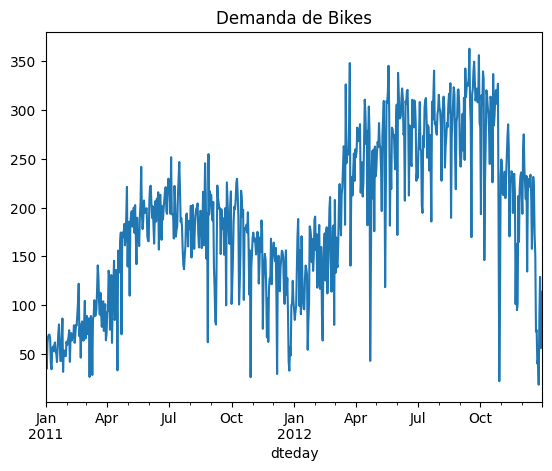

In [6]:
# Reajuste da demanda pela média de aluguel por dia.
data.set_index('dteday')['cnt'].resample('D').mean().plot(title='Demanda de Bikes');

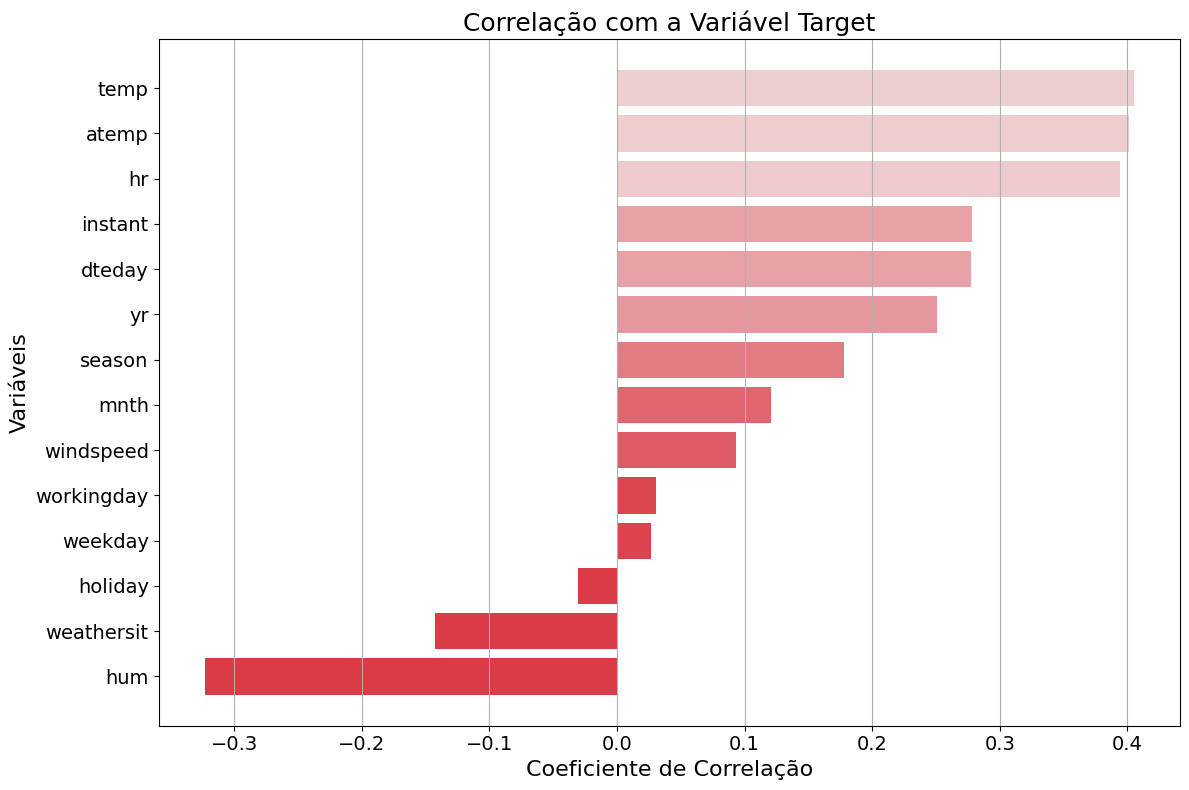

In [17]:
# Função para verificar a correlação das variáveis independentes com a target
correlation_plot = plot_correlation_with_demand(data, save_path="../report/figures/correlation_plot.png")
correlation_plot

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Matriz de Correlação', fontsize=18)
sns.heatmap(data.corr(), annot=True, fmt=".1f");

# Pré-Processamento

In [7]:
# Divisão 80% treino e 20% para validação.
train = data.loc[data['dteday']< '2012-08-10']
valid = data.loc[data['dteday']>= '2012-08-10']

# Porcentagem dos dados de treino
round(train.shape[0] / data.shape[0], 2)

0.8

In [8]:
# Removendo as variáveis 'instant', 'dteday'
train.drop(['instant', 'dteday'], axis=1, inplace=True)
valid.drop(['instant', 'dteday'], axis=1, inplace=True)

In [ ]:
# Salva os datasets pré-processados
train.to_csv('../data/processed/train.csv',index=False)
valid.to_csv('../data/processed/valid.csv',index=False)

In [9]:
# Separando as variáveis preditoras da variável target
train_x = train.drop(columns='cnt')
train_y = train['cnt']
valid_x = valid.drop(columns='cnt')
valid_y = valid['cnt']

# XGBoost Data Format
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Configurando o MLflow Experiment

In [10]:
# Cria o experimento no MLflow
experiment_id = mlflow.create_experiment("Bike Demand")

In [11]:
experiment_id

'455374056919817154'

In [12]:
# Define o experimento a ser usado
mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='mlflow-artifacts:/455374056919817154', creation_time=1740851693147, experiment_id='455374056919817154', last_update_time=1740851693147, lifecycle_stage='active', name='Bike Demand', tags={}>

# Hyperparameter Tuning

**Logging para gerenciar as saídas**

A medida que realizamos o ajuste de hiperparâmetros com o Optuna, é essencial entender que o processo pode gerar uma infinidade de execuções. Na verdade, tantas que a saída padrão (stdout) do registrador padrão pode rapidamente ficar inundada, produzindo páginas e mais páginas de relatórios de registro.

Embora a verbosidade da configuração de registro padrão seja inegavelmente valiosa durante a fase de desenvolvimento do código, iniciar um teste em grande escala pode resultar em uma quantidade avassaladora de informações. Considerando isso, registrar cada detalhe no stdout se torna menos prático, especialmente quando temos ferramentas dedicadas como o MLflow para rastrear meticulosamente nossos experimentos.

In [13]:
# override Optuna's default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [23]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            # defines booster, gblinear for linear functions.
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            # L2 regularization weight.
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            # L1 regularization weight.
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            # sampling ratio for training data.
            "subsample": trial.suggest_float("subsample", 0.2, 1.0),
            # sampling according to each tree.
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        }

        if params["booster"] == "gbtree" or params["booster"] == "dart":
            # maximum depth of the tree, signifies complexity of the tree.
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            # minimum child weight, larger the term more conservative the tree.
            params["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
            # taxa de aprendizado
            params["learning_rate"] = trial.suggest_float("learning_rate", 1e-8, 1.0, log=True)
            # controla a poda
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)

        # Train XGBoost model
        bst = xgb.train(params, dtrain, num_boost_round=500)
        preds = bst.predict(dvalid)
        error = mean_squared_error(valid_y, preds)

        # Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metric("mse", error)
        mlflow.log_metric("rmse", math.sqrt(error))

    return error


# Orchestrating Hyperparameter Tuning, Model Training, and Logging with MLflow

In [24]:
#run_name = "500trails_100num_boost"
run_name = "500trails_500num_boost"

In [25]:
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    # Initialize the Optuna study
    study = optuna.create_study(direction="minimize")

    # Execute the hyperparameter optimization trials.
    # Note the addition of the `champion_callback` inclusion to control our logging
    study.optimize(objective, n_trials=500, callbacks=[champion_callback])

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_mse", study.best_value)
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Bike Demand Project",
            "optimizer_engine": "optuna",
            "model_family": "xgboost",
            "feature_set_version": 1,
        }
    )

    # Log a fit model instance
    model = xgb.train(study.best_params, dtrain)

    # Log the correlation plot
    mlflow.log_figure(figure=correlation_plot, artifact_file="correlation_plot.png")

    # Log the feature importances plot
    importances = plot_feature_importance(model, booster=study.best_params.get("booster"))
    mlflow.log_figure(figure=importances, artifact_file="feature_importances.png")

    # Log the residuals plot
    residuals = plot_residuals(model, dvalid, valid_y)
    mlflow.log_figure(figure=residuals, artifact_file="residuals.png")

    artifact_path = "model"

    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=train_x.iloc[[0]],
        model_format="ubj",
        metadata={"model_data_version": 1},
    )

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)


🏃 View run nosy-kite-751 at: http://localhost:5000/#/experiments/455374056919817154/runs/b2cb4b72107840aeaf62fb350c5f1be9
🧪 View experiment at: http://localhost:5000/#/experiments/455374056919817154
Initial trial 0 achieved value: 33346.23828125
🏃 View run caring-hog-315 at: http://localhost:5000/#/experiments/455374056919817154/runs/b72f3d7174244458b4e35aa597645fc9
🧪 View experiment at: http://localhost:5000/#/experiments/455374056919817154
🏃 View run delightful-koi-343 at: http://localhost:5000/#/experiments/455374056919817154/runs/8b9d7a50ef5b40419fb6c0cd287aa46d
🧪 View experiment at: http://localhost:5000/#/experiments/455374056919817154
Trial 2 achieved value: 4609.58154296875 with  623.4114% improvement
🏃 View run dapper-turtle-571 at: http://localhost:5000/#/experiments/455374056919817154/runs/06d1e86e36d44cd0bec7ce88c3f76235
🧪 View experiment at: http://localhost:5000/#/experiments/455374056919817154
🏃 View run valuable-squirrel-91 at: http://localhost:5000/#/experiments/455374

2025/03/01 19:40:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run 500trails_500num_boost at: http://localhost:5000/#/experiments/455374056919817154/runs/ba70d2737fbb45db8e8feed20cde3f72
🧪 View experiment at: http://localhost:5000/#/experiments/455374056919817154


In [26]:
study.trials_dataframe().sort_values(by='value', ascending=True).head(10)

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_booster,params_colsample_bytree,params_gamma,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_subsample,state
377,377,3873.951172,2025-03-01 18:37:59.983664,2025-03-01 18:38:32.566001,0 days 00:00:32.582337,1.206889e-07,dart,0.954679,1.940822e-08,1.191960e-07,0.071424,6.0,5.0,0.538769,COMPLETE
264,264,3875.004395,2025-03-01 17:41:55.598204,2025-03-01 17:42:27.332109,0 days 00:00:31.733905,2.906689e-08,dart,0.940957,6.162300e-04,8.708750e-08,0.089234,6.0,7.0,0.583832,COMPLETE
354,354,3891.382080,2025-03-01 18:26:37.633257,2025-03-01 18:27:09.466532,0 days 00:00:31.833275,1.714351e-07,dart,0.923981,3.927092e-03,4.981153e-07,0.067838,6.0,10.0,0.532896,COMPLETE
473,473,3898.275391,2025-03-01 19:25:57.969267,2025-03-01 19:26:30.521680,0 days 00:00:32.552413,7.884627e-08,dart,0.999781,5.714773e-04,2.129885e-06,0.064250,6.0,9.0,0.550405,COMPLETE
400,400,3933.514648,2025-03-01 18:49:31.217529,2025-03-01 18:50:04.869800,0 days 00:00:33.652271,2.411409e-07,dart,0.985989,1.479394e-03,3.151038e-06,0.072694,6.0,10.0,0.618974,COMPLETE
212,212,3948.048096,2025-03-01 17:13:33.606669,2025-03-01 17:14:06.029922,0 days 00:00:32.423253,4.127430e-08,dart,0.928409,3.340676e-03,2.166754e-01,0.091678,6.0,10.0,0.605904,COMPLETE
359,359,3951.940674,2025-03-01 18:29:22.849949,2025-03-01 18:29:54.933304,0 days 00:00:32.083355,1.772608e-07,dart,0.983290,3.767341e-08,2.961154e-07,0.084909,6.0,8.0,0.512727,COMPLETE
437,437,3955.550537,2025-03-01 19:08:01.635075,2025-03-01 19:08:35.083998,0 days 00:00:33.448923,4.969416e-07,dart,0.999042,5.191070e-04,2.550785e-08,0.096954,6.0,10.0,0.485268,COMPLETE
321,321,3963.860352,2025-03-01 18:10:10.464220,2025-03-01 18:10:42.414576,0 days 00:00:31.950356,7.431467e-08,dart,0.971956,1.467501e-08,7.323580e-07,0.088426,6.0,8.0,0.530814,COMPLETE
289,289,3967.923340,2025-03-01 17:54:16.413060,2025-03-01 17:54:48.696837,0 days 00:00:32.283777,8.137753e-08,dart,0.941290,2.255275e-05,7.775847e-02,0.129745,6.0,10.0,0.546618,COMPLETE


In [27]:
study.best_params

{'booster': 'dart',
 'lambda': 1.1919597873532319e-07,
 'alpha': 1.2068892435517592e-07,
 'subsample': 0.5387693079786154,
 'colsample_bytree': 0.9546786424658474,
 'max_depth': 6,
 'min_child_weight': 5,
 'learning_rate': 0.07142445545084196,
 'gamma': 1.9408218269879743e-08}

# Loading the Trained Model with MLflow

In [28]:
model_uri

'mlflow-artifacts:/455374056919817154/ba70d2737fbb45db8e8feed20cde3f72/artifacts/model'

In [29]:
loaded = mlflow.xgboost.load_model(model_uri)

In [30]:
batch_dmatrix = xgb.DMatrix(valid_x)

inference = loaded.predict(batch_dmatrix)

infer_data = valid.copy()

infer_data["predicted_demand"] = inference

In [31]:
infer_data["predicted_demand"] = infer_data["predicted_demand"].astype(int)
infer_data

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,predicted_demand
13963,3,1,8,0,0,5,1,1,0.70,0.6515,0.65,0.0896,85,114
13964,3,1,8,1,0,5,1,1,0.70,0.6515,0.65,0.1045,41,100
13965,3,1,8,2,0,5,1,1,0.70,0.6667,0.74,0.1642,20,94
13966,3,1,8,3,0,5,1,2,0.72,0.6970,0.79,0.1940,9,109
13967,3,1,8,4,0,5,1,3,0.70,0.6667,0.84,0.2836,7,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119,185
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89,156
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90,138
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61,125


In [32]:
infer_data[['cnt','predicted_demand']].describe()

,cnt,predicted_demand
count,3416.000000,3416.000000
mean,247.331382,193.991803
std,219.750910,77.703788
min,1.000000,86.000000
25%,52.000000,118.000000
50%,203.000000,194.000000
75%,365.000000,250.000000
max,977.000000,411.000000
